In [1]:
import pyfits
import os
import pyfits
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
from astropy.cosmology import WMAP9 as cosmo
import matplotlib
import math
from scipy import ndimage
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
from scipy.ndimage import iterate_structure
from scipy.ndimage.filters import maximum_filter
import scipy.optimize as opt
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from astropy.io import fits
import math
import photutils
import statmorph
from skimage import measure

'''imports a million things'''
import pyfits
from photutils import CircularAperture,aperture_photometry




XTENSION= 'IMAGE   '           / IMAGE extension                                BITPIX  =                  -32 / number of bits per data pixel                  NAXIS   =                    2 / number of data axes                            NAXIS1  =                  300 / length of data axis 1                          NAXIS2  =                  300 / length of data axis 2                          PCOUNT  =                    0 / required keyword; must = 0                     GCOUNT  =                    1 / required keyword; must = 1                     EXTNAME = 'CAMERA0-PARAMETERS'                                                  HDUVERS =                    1                                                  COMMENT This HDU contains the camera parameters. The image contains the solid anCOMMENT gle subtended by the individual pixels.                                 HISTORY This HDU was created by Sunrise (class camera_base) version , on Fri JulHISTORY  20 23:29:19 2018 by user lblech

<Figure size 576x396 with 0 Axes>

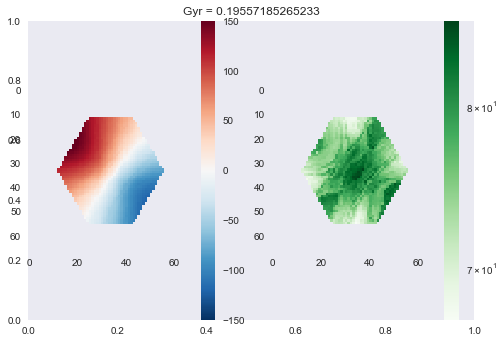

NameError: name 'STOP' is not defined

In [176]:
myr_list = [10,20,40,60,80,100,120,140,160,170,180,185,190,200,205,210,220,225,230,240,250,260,265,275,285,295,305,311,315]

#for fg3_m13:
myr_list = [20,40,70,80,100,120,140,150,170,180,190,210,220,230,235,237,
     240,242,245,247,250,252,255,257,262,265,270,275,280,285,
     287,288,289,290,295,300,305]
run='fg3_m13'
AGN=[]
for j in range(len(myr_list)):
    view = 5
    myr=myr_list[j]
    plt.clf()
    try:
        cube = pyfits.open('stellar_kinematics_NONSCATTER_kin_correct_noise_conv_'+run+'_'+str(myr)+'_'+str(view)+'.fits')
    except FileNotFoundError:
        continue
    if run=='fg3_m12':
        if myr <170:
            if myr < 100:
                prefix = '0'
            else:
                prefix = ''
            im = pyfits.open('../LAURA_Sims/q0.5_fg0.3_allrx10_sunruns/hires_kin_early_cen1/broadband_'+prefix+str(myr)+'.fits')
        else:
            im = pyfits.open('../LAURA_Sims/q0.5_fg0.3_allrx10_sunruns/hires_kin/broadband_'+str(myr)+'.fits')
    if run=='fg3_m13':
        if myr < 150:
            if myr < 10:
                prefix = '00'
            else:
                if myr < 100:
                    prefix= '0'
                else:
                    prefix = ''
            im = pyfits.open('../LAURA_Sims/q0.333_fg0.3_allrx10_sunruns/hires_kin_early_cen1/broadband_'+prefix+str(myr)+'.fits')
        else:
            im = pyfits.open('../LAURA_Sims/q0.333_fg0.3_allrx10_sunruns/hires_kin_late/broadband_'+str(myr)+'.fits')
    
    print(im['CAMERA0-PARAMETERS'].header)
    
    age = im['SFRHIST'].header['SNAPTIME']/10**9
    vel = ma.masked_where(cube[1].data==0, cube[1].data)
    sig = ma.masked_where(cube[1].data==0, cube[3].data)
    if np.max(sig)>500:
        print('AGN contamination', np.max(sig))
        AGN.append(myr)
    plt.clf()
    fig=plt.figure()
    plt.title('Gyr = '+str(age))
    ax0 = fig.add_subplot(121)
    im0 = ax0.imshow(vel, cmap='RdBu_r', vmin=-150, vmax=150)
    plt.colorbar(im0)
    ax1 = fig.add_subplot(122)
    im1 = ax1.imshow(sig, cmap='Greens', norm=matplotlib.colors.LogNorm())
    plt.colorbar(im1)
    plt.show()
    STOP
print('AGN contamination', AGN)

In [4]:
'''This is to make a kinematic mosaic side by side with imagin'''

#for fg3_m13:
myr_list = [20,40,70,80,100,120,140,150,170,180,190,210,220,230,235,237,
     240,242,245,247,250,252,255,257,262,265,270,275,280,285,
     287,288,289,290,295,300,305]

run='fg3_m12'
AGN=[]
for j in range(len(myr_list)):
    view = 5
    myr=myr_list[j]
    plt.clf()
    try:
        cube = pyfits.open('stellar_kinematics_NONSCATTER_kin_correct_noise_conv_'+str(run)+'_'+str(myr)+'_'+str(view)+'.fits')
    except FileNotFoundError:
        continue
    if run=='fg3_m12_agnx0':
        if myr <170:
            if myr < 100:
                prefix = '0'
            else:
                prefix = ''
            im = pyfits.open('../LAURA_Sims/q0.5_fg0.3_allrx10_sunruns/agnx0/broadband_'+prefix+str(myr)+'.fits')
        else:
            im = pyfits.open('../LAURA_Sims/q0.5_fg0.3_allrx10_sunruns/agnx0/broadband_'+str(myr)+'.fits')
    
    if run=='fg3_m12':
        
        if myr <170:
            if myr < 100:
                prefix = '0'
            else:
                prefix = ''
            im = pyfits.open('../LAURA_Sims/q0.5_fg0.3_allrx10_sunruns/hires_kin_early_cen1/broadband_'+prefix+str(myr)+'.fits')
        else:
            im = pyfits.open('../LAURA_Sims/q0.5_fg0.3_allrx10_sunruns/hires_kin/broadband_'+str(myr)+'.fits')
    if run=='fg3_m13':
        if myr < 150:
            if myr < 10:
                prefix = '00'
            else:
                if myr < 100:
                    prefix= '0'
                else:
                    prefix = ''
            im = pyfits.open('../LAURA_Sims/q0.333_fg0.3_allrx10_sunruns/hires_kin_early_cen1/broadband_'+prefix+str(myr)+'.fits')
        else:
            im = pyfits.open('../LAURA_Sims/q0.333_fg0.3_allrx10_sunruns/hires_kin_late/broadband_'+str(myr)+'.fits')
    
    
    
    age = im['SFRHIST'].header['SNAPTIME']/10**9
      
    r_band = ma.masked_where(cube[1].data==0, cube[5].data)  
    r_band = ma.masked_where(r_band > 10**5, r_band)
        
    vel = ma.masked_where(cube[1].data==0, cube[1].data)
    sig = ma.masked_where(cube[1].data==0, cube[3].data)
    if np.max(sig)>500:
        print('AGN contamination', np.max(sig))
        AGN.append(myr)
    plt.clf()
    fig=plt.figure()
    #plt.title('Gyr = '+str(myr))
    axlabel = fig.add_subplot(131)
    axlabel.annotate(str(round(age,2))+' Gyr', xy=(0.85,0.48), xycoords='axes fraction', size=15)
    axlabel.axis('off')
    
    ax0 = fig.add_subplot(132)
    im0 = ax0.imshow(r_band, cmap='afmhot_r')#norm=matplotlib.colors.LogNorm(vmin=np.min(r_band),vmax=np.max(r_band)+1000))
    plt.colorbar(im0, fraction=0.05)
    ax0.axis('off')
    if j ==0:
        ax0.set_title('$r-$band Flux\n', size=15)
    
    
    ax1 = fig.add_subplot(133)
    im1 = ax1.imshow(vel, cmap='RdBu_r', vmin=-150, vmax=150)
    plt.colorbar(im1, fraction=0.05)
    if j ==0:
        ax1.set_title('Stellar Velocity\n', size=15)
    ax1.axis('off')
    
    '''ax2 = fig.add_subplot(133)
    im2 = ax2.imshow(sig, cmap='Greens',   norm=matplotlib.colors.LogNorm())
    plt.colorbar(im2, fraction=0.05)
    ax2.set_title('Stellar Velocity\nDispersion')
    ax2.axis('off')'''
    plt.tight_layout()
    plt.savefig('mosaic_fig_ani_'+str(run)+'_'+str(myr)+'.pdf')
print('AGN contamination', AGN)

/Users/beckynevin/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


AGN contamination 1000.0000000000001
AGN contamination [210]


In [ ]:

import cv2
def determine_coords(img):
    
    '''Apply a 10x10 kernal to the image to filter out noise (its basically a low pass filter)
    to smooth things out'''
    kernel = np.ones((10,10))

    lp = ndimage.convolve(img, kernel)#was result
    '''plt.clf()
    plt.imshow(lp)
    plt.title('Low Pass Filter')
    plt.show()'''
    
    '''Okay here is where you can filter out the really low stuff
    (anything below 20% of the max is eliminated so that we can detect the peak pixel)'''
    
    max_value=(lp.max())
    low = np.where(lp < 0.2*max_value)
    
   
    lp[low] = 0
    
    
    
    
    
    
    '''Detects brightest peaks in an image (can dcometect more than 1)'''
    indices = np.where(detect_peaks(lp) == 1)#was hp_lp_sharp
    
    number_of_sols=len(indices[0])
    
    
    try:
        return indices[0][0],indices[0][-1],indices[1][0],indices[1][-1], lp, number_of_sols
    except IndexError:
        #if there are no peaks this means the simulation was somehow cut off and
        #starting with returning zeros will flag the entire procedure to continue
        #without further ado
        return 0,0,0,0,lp,number_of_sols

def detect_peaks(image):
    """
    Takes an image and detect the peaks using the local maximum filter.
    Returns a boolean mask of the peaks (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """

    # define an 8-connected neighborhood
    struct = generate_binary_structure(2,1)
    
    neighborhood = iterate_structure(struct, 10).astype(bool)
    
    #apply the local maximum filter; all pixel of maximal value 
    #in their neighborhood are set to 1
    local_max = maximum_filter(image, footprint=neighborhood)==image
    #local_max is a mask that contains the peaks we are 
    #looking for, but also the background.
    #In order to isolate the peaks we must remove the background from the mask.
    
    
    #we create the mask of the background
    background = (image==0)

    #a little technicality: we must erode the background in order to 
    #successfully subtract it form local_max, otherwise a line will 
    #appear along the background border (artifact of the local maximum filter)
    eroded_background = binary_erosion(background, structure=neighborhood, border_value=1)

    #we obtain the final mask, containing only peaks, 
    #by removing the background from the local_max mask (xor operation)
    detected_peaks = local_max ^ eroded_background

    return detected_peaks

'''
Fits 2D gaussians to surface brightness using the guesses from the low pass filter of the galaxy locations
Basically, this is my own design of a rough precursor to Source Extractor
'''
def fit_2_gaussian(x_1,y_1,x_2,y_2, data):
    # Create x and y indices
    data=np.flipud(data)
    x = np.linspace(0, np.shape(data)[0]-1,np.shape(data)[0])
    y = np.linspace(0, np.shape(data)[1]-1, np.shape(data)[1])
    x, y = np.meshgrid(x, y)
    

    
    plt.clf()
    fig, ax = plt.subplots(1, 1)
    ax.hold(True)
    #im = ax.imshow(data, cmap=plt.cm.jet, origin='bottom')#
    cs = ax.contour(x, y, data, 8, colors='w')
    plt.clf()
    
    p = cs.levels#collections[0].get_paths()[0]
    
    
    '''Now, snatch the last level and use it to blur everything else out and find the center'''
    
    
    '''now fill with zeros and do your best to turn into a binary bitmask'''
    ret,thresh = cv2.threshold(data,p[-1],2000,cv2.THRESH_BINARY)

    M = cv2.moments(thresh)
    
    
 
    # calculate x,y coordinate of center
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    
    
    
    return cX, np.shape(data)[0]-cY
    #return popt[1], popt[2], popt[8], popt[9], popt[0], popt[7], np.sqrt(popt[3]**2+popt[4]**2), np.sqrt(popt[10]**2+popt[11]**2), fit 


def twoD_two_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset,
                     amplitude_2, xo_2, yo_2, sigma_x_2, sigma_y_2, theta_2):
    (x, y) = xdata_tuple 
    xo = float(xo)
    yo = float(yo)   
    xo_2 = float(xo_2)
    yo_2 = float(yo_2)  
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    
    a_2 = (np.cos(theta_2)**2)/(2*sigma_x_2**2) + (np.sin(theta_2)**2)/(2*sigma_y_2**2)
    b_2 = -(np.sin(2*theta_2))/(4*sigma_x_2**2) + (np.sin(2*theta_2))/(4*sigma_y_2**2)
    c_2 = (np.sin(theta_2)**2)/(2*sigma_x_2**2) + (np.cos(theta_2)**2)/(2*sigma_y_2**2)
    
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))+ amplitude_2*np.exp( - (a_2*((x-xo_2)**2) + 2*b_2*(x-xo_2)*(y-yo_2) 
                            + c_2*((y-yo_2)**2)))
    
    return g.ravel()


'''Now it begins'''

def compare_centers(image, disp, x_kin, y_kin, z):


    b=determine_coords(image.filled(fill_value=0))
    #this determines the locations of the galaxies



    '''if b[0]==0:
        #if the first index from determine_coords is zero, the galaxy is out of the image
        #and we can continue and skip this particular image (sometimes other viewpoints of
        #the same snapshot are in the frame so don't get rid of an entire snapshot)
        STOP'''








    low_pass=b[4]
    num_sol=b[5]

    

    '''Now, fit a couple 2D gaussians if there are 2 brightest pixels, otherwise
    fit only one 2D gaussian. The output of fit_2_gaussians will be the positions of these
    maxima'''
    from numpy import shape

    if num_sol==1:
        #this is if there's only really one solution because the bulges are too close together
        #fit a 2D gaussian to center the previous guess of peak pixels using the entire surface
        #brightness profile
        c=fit_2_gaussian(b[1],shape(image)[0]-b[0],b[1],shape(image)[0]-b[0],low_pass)
        #if c[8]=='no':
        #     c=fit_2_gaussian(b[2],shape(image)[0]-b[0],b[3],shape(image)[0]-b[1],low_pass)

    else:
        c=fit_2_gaussian(b[2],shape(image)[0]-b[0],b[3],shape(image)[0]-b[1],low_pass)



    
    
    img_cen_x = c[0]
    img_cen_y = c[1]
    
    b=determine_coords(disp.filled(fill_value=0))
    #this determines the locations of the galaxies



    '''if b[0]==0:
        #if the first index from determine_coords is zero, the galaxy is out of the image
        #and we can continue and skip this particular image (sometimes other viewpoints of
        #the same snapshot are in the frame so don't get rid of an entire snapshot)
        STOP'''








    low_pass=b[4]
    num_sol=b[5]

    

    '''Now, fit a couple 2D gaussians if there are 2 brightest pixels, otherwise
    fit only one 2D gaussian. The output of fit_2_gaussians will be the positions of these
    maxima'''
    from numpy import shape

    if num_sol==1:
        #this is if there's only really one solution because the bulges are too close together
        #fit a 2D gaussian to center the previous guess of peak pixels using the entire surface
        #brightness profile
        c=fit_2_gaussian(b[1],shape(disp)[0]-b[0],b[1],shape(disp)[0]-b[0],low_pass)
        

    else:
        c=fit_2_gaussian(b[2],shape(disp)[0]-b[0],b[3],shape(disp)[0]-b[1],low_pass)



    '''if c[4] > c[5]:
        in_x = c[1]
        in_y = c[0]
        in_2_x = c[3]
        in_2_y = c[2]


    if c[5] > c[4]:
        in_x = c[3]
        in_y = c[2]
        in_2_x = c[1]
        in_2_y = c[0]'''

    disp_cen_x = c[0]
    disp_cen_y = c[1]
    
    plt.clf()
    fig = plt.figure()
    ax0 = fig.add_subplot(121)
    im0 = ax0.imshow(image, cmap='rainbow')
    plt.scatter(img_cen_x, img_cen_y, color='black', marker='x')
    plt.scatter(x_kin, y_kin, color='orange', marker='x')
    plt.title('$r-$band Image')
    plt.colorbar(im0)
    
    ax1 = fig.add_subplot(122)
    im1 = ax1.imshow(disp, cmap='rainbow')
    plt.scatter(disp_cen_x,disp_cen_y, color='black', marker='x')
    plt.title('Dispersion')
    plt.colorbar(im1)
    plt.show()
#    plt.savefig('centering_check')
    kpc_arcsec=(cosmo.kpc_proper_per_arcmin(z).value/60)
    spax_to_kpc = 0.5*kpc_arcsec
    
    
    print('kpc/arcsec', kpc_arcsec, 'spax_to_kpc', spax_to_kpc)
    print('delta x', spax_to_kpc*np.sqrt((img_cen_x-disp_cen_x)**2+(img_cen_y-disp_cen_y)**2))
    print('delta x 2', spax_to_kpc*np.sqrt((img_cen_x-x_kin)**2+(img_cen_y-y_kin)**2))
    STOP
    
    return spax_to_kpc*np.sqrt((img_cen_x-disp_cen_x)**2+(img_cen_y-disp_cen_y)**2), spax_to_kpc*np.sqrt((img_cen_x-x_kin)**2+(img_cen_y-y_kin)**2)


def convolve_spatially(input_data,factor, plot):
    if ((len(input_data[:,0])/factor).is_integer()):
        length=int(len(input_data[:,0])/factor)
    else:
        stop


    data_new = np.zeros(( length, length))

    data_new += input_data[ ::factor, ::factor] + input_data[ 1::factor, ::factor] + input_data[ ::factor, 1::factor] + input_data[ 1::factor, 1::factor]# Take (0,0)                                                                                                               \
                                                                                                                                                

    return data_new
def get_center_kin(view,myr, broadband):
    '''We need to take the r-band image and find the brightest 25% of the pixels'''
    plt.imshow(broadband)
    plt.show()
    sort_list=np.sort(broadband, axis=None)     # sort the flattened array
    #print('sort list', sort_list)
    
    '''Go through and pull out all the unmasked elements of the sorted list'''
    sort_list_real=[]
    for i in range(len(sort_list)):
        if math.isnan(sort_list[i]):
            continue
        else:
            sort_list_real.append(sort_list[i])
    sort_list_real=np.array(sort_list_real)
    '''Sorts in increasing order, make a cutoff for the top 25% of pixels and mask'''
    value = (sort_list_real[int(len(sort_list_real)*0.75)])
    max_filter=ma.masked_where(broadband < value, broadband)
    
    
    '''Now calculate a weighted average of x and y pos'''
    #weighted_avg = np.average(rate, weights=amount)
    xs=[]
    ys=[]
    weight=[]
    for i in range(np.shape(max_filter)[0]):
        for j in range(np.shape(max_filter)[1]):
            
            if ma.is_masked(max_filter[i][j]):
                continue
            else:
                xs.append(i)
                ys.append(j)
                weight.append(max_filter[i][j])
    #print('weight', weight)
    avg_x=np.average(xs, weights=weight)
    avg_y=np.average(ys, weights=weight)
    '''print('avg_x', avg_x, 'avg_y', avg_y)
    
    plt.imshow(max_filter,norm=matplotlib.colors.LogNorm())
    plt.title('Max filter')
    plt.scatter(avg_x, avg_y, color='r')
    #plt.colorbar()
    plt.show()'''
            
    return avg_x, avg_y


def get_center(view, myr, run, image, pixelscale, z):
    
    x_cen=0
    y_cen=0
    
    
    b=determine_coords(image)
    #this determines the locations of the galaxies

    if b[0]==0:
        #if the first index from determine_coords is zero, the galaxy is out of the image
        #and we can continue and skip this particular image (sometimes other viewpoints of
        #the same snapshot are in the frame so don't get rid of an entire snapshot)
        
        return 0, 0, 1, 0







    low_pass=b[4]
    num_sol=b[5]

    '''Now, fit a couple 2D gaussians if there are 2 brightest pixels, otherwise
    fit only one 2D gaussian. The output of fit_2_gaussians will be the positions of these
    maxima'''

    if num_sol==1:
        #this is if there's only really one solution because the bulges are too close together
        #fit a 2D gaussian to center the previous guess of peak pixels using the entire surface
        #brightness profilede
        c=fit_2_gaussian(b[1],np.shape(image)[0]-b[0],b[1],np.shape(image)[0]-b[0],low_pass)
        #if c[8]=='no':
        #     c=fit_2_gaussian(b[2],np.shape(image)[0]-b[0],b[3],np.shape(image)[0]-b[1],low_pass)

    else:
        c=fit_2_gaussian(b[2],np.shape(image)[0]-b[0],b[3],np.shape(image)[0]-b[1],low_pass)



    if c[4] > c[5]:
        '''this means point 1 is brighter'''
        in_x = c[1]
        in_y = c[0]
        in_2_x = c[3]
        in_2_y = c[2]


    if c[5] > c[4]:
        '''point 2 is the brighter source'''
        in_x = c[3]
        in_y = c[2]
        in_2_x = c[1]
        in_2_y = c[0]




    '''Now place a aperture over each center and figure out which is brighter overall'''
    c_final=determine_brighter(image,  in_y,np.shape(image)[0]-in_x,  in_2_y, np.shape(image)[0]-in_2_x, pixelscale, z)

    #if c_final[2]=='yes':
    #    return 0, 0, 1, 0

    if c_final[0] > c_final[1]:
        #Clip the image in the SDSS imaging size around 
        d=clip_image(image, pixelscale, z, int(np.shape(image)[0]-in_x), int(in_y))
        #this means the first aperture (center) is indeed brighter
    else:
        d=clip_image(image, pixelscale, z, int(np.shape(image)[0]-in_2_x), int(in_2_y))

    if d[3]=='no':
        #this means the cutout is outside the image --> bad
        
        return 0, 0, 1, 0
 
    x_cen=d[4]
    y_cen=d[5]
    
    if x_cen==0 or y_cen==0:
        flag=1
    else:
        flag=0
    
    
    '''Now, trying to get the segmap to mask your kinematic map'''
    '''Now we need to clip this so that its the size of an SDSS image 
    (50" by 50" in diameter)'''
    '''You also need to use the redshift to get an accurate cutout, here its 0.03, the
    mean redshift of MaNGA'''


    '''d output is surfadef mce brightness in W/m/m^2/sr but cut'''

    '''Next, convert to this weird nanomag unit that SDSS tends to use:
    The standard source for each SDSS band is close to but not exactly 
    the AB source (3631 Jy), meaning that a nanomaggy is approximately 3.631×10-6 Jy,
    which is the conversion we use here.
    Note that nanomaggies are still a unit of surface brightness so we can use nanomaggies
    later in the code to compute the nonparametric quantities Gini, M20, C, A, and S.'''
    '''Nanomags also does a couple of important image processing steps like introduce a sky
    background that is typical for SDSS imaging as well a constructs a Poisson noise map.'''
    e=nanomags(z, pixelscale, d[0],view, myr)


    #Size is determined by what?                                                                                                                                                                                                                   
    #arc_size of                                                                                                                                                                                                                                   
    #return clipped, size_a, num_pix_half, tag, xcen, ycen                                                                                                                                                                                         
    kpc_arcmin=cosmo.kpc_proper_per_arcmin(z)
    size_a = pixelscale/(kpc_arcmin.value/60)#now we're in "/pix                                                                                                                                                                                   
    pix_size = d[2]
    size = int(pix_size*size_a) #now we're in units of " of one side of the thing                                                                                                                                                                  

    prep=convolve_rebin_image(myr,z,pixelscale,view, e, size)
    #def convolve_rebin_image(number, z, pixscale, view, counts, size):                                                                                                                                                                            
    '''The second extension here is the S_N in r-band'''
    plt.clf()

    fig=plt.figure()
    ax0=fig.add_subplot(211)
    im0=ax0.imshow(prep[0], norm=matplotlib.colors.LogNorm(), cmap='afmhot_r')
    ax0.set_title('Counts')
    plt.colorbar(im0)

    masked_S_N = ma.masked_where(prep[0] < 1, prep[1])
    g_band_signal = ma.masked_where(prep[0] < 1, prep[0])
    masked_S_N = ma.masked_where(np.abs(masked_S_N) < 1, masked_S_N)



    ax1=fig.add_subplot(212)
    im1=ax1.imshow(masked_S_N, norm=matplotlib.colors.LogNorm(), cmap='afmhot_r')
    ax1.set_title('S/N')
    plt.colorbar(im1)
    plt.savefig('S_N_g_band.png')

    return x_cen, y_cen, flag, d[2], g_band_signal, masked_S_N#g_band_signal/masked_S_N 

'''Now I have to convert the units of LAURAS sims into nanomaggies and AB mags (mags of DR7 and DR13)
'''
def nanomags(z, pixscale, camera_data, view, number):

    c = 299792.458*1000#to get into m/s                                                                                                                                                                                                            



    pixelscale=pixscale
    from astropy.cosmology import FlatLambdaCDM
    cosmo = FlatLambdaCDM(H0=70,Om0=0.3)
    d_A = cosmo.comoving_distance(z).value/(1+z)
    #here's a good review of all the different distances cosmology distances:                                                                                                                                                                      
    #http://www.astro.ufl.edu/~guzman/ast7939/projects/project01.html                                                                                                                                                                              

    #Convert from specific intensity units (W/m/m^2/sr) from SUNRISE to Janskies (W/Hz/m^2):                                                                                                                                                       
    Janskies=np.array(10**(26)*camera_data*(pixelscale/(1000*d_A))**2*np.pi*((6185.2*10**(-10))**2/c), dtype='>f4')
    #this 1.35e-6 comes from the arcsin(R_sky/Distance to object)                                                                                                                                                                                  
    #the answer needs to be in radians                                                                                                                                                                                                             

    #J=10^-26 W/m^2/Hz, so units of flux density                                                                                                                                                                                                   
    #reference site: http://www.cv.nrao.edu/course/astr534/Brightness.html                                                                                                                                                                         
    #We need to go from a spectral brightness (I_nu) which is in m units                                                                                                                                                                           
    #To a flux density (S_nu) which is in units of Janskies (W/m^2/Hz)                                                                                                                                                                             

    #So you need to multiply the Fν by c / λ^2 to convert it into Fλ.                                                                                                                                                                              
    #But we are not done yet! Recalling from above, the units of Fλ                                                                                                                                                                               
    #are not an energy density. You need to get another factor of λ                                                                                                                                                                               
    #in there to make the units work out to be energy density:                                                                                                                                                                                     
    #calculate λFλ to get units of ergs/s/cm^2.                                                                                                                                                                                                    

    Janskies_bright = Janskies*100**(1/5)

    nanomaggy=Janskies_bright/(3.631*10**(-6))


    '''Now convert into the correct background:)'''

    #nanomaggies and stuff: (Finkbeiner et al. 2004)                                                                                                                                                                                               

    '''The average background and std as well as the readnoise and gain                                                                                                                                                                            
    are from another code of mine:                                                                                                                                                                                                                 
        SDSS_noise_imaging/SDSS_r_imaging.ipynb'''

    #first, convert to counts (dn) using the average value of cimg from the SDSS frame images                                                                                                                                                      
    #dn=img/cimg+simg                                                                                                                                                                                                                              
    cimg=0.003813475#0.005005225 #nanomaggies/count                                                                                                                                                                                                
    gain=3.85#4.735                                                                                                                                                                                                                                
    darkvar=3.875#1.1966                                                                                                                                                                                                                           
    simg=63.711#121.19590411 #average background value (counts) pre background subraction (used to calculate poisson error)                                                                                                                        
    counts=(nanomaggy)/cimg#+simg                                                                                                                                                                                                                  
    '''sigma_counts=np.sqrt(counts/gain+darkvar)                                                                                                                                                                                                   
    sigma_nanomags=sigma_counts*cimg                                                                                                                                                                                                               
                                                                                                                                                                                                                                                   
    nanomag_bg = counts*cimg                                                                                                                                                                                                                       
                                                                                                                                                                                                                                                   
                                                                                                                                                                                                                                                   
    sky_resids_mine=cimg*np.random.normal(0.77, 3.73, np.shape(nanomaggy))#0.331132,5.63218,np.shape(nanomaggy))                                                                                                                                   
    sky_resids_mine_counts=np.random.normal(0.77, 3.73, np.shape(nanomaggy))#0.331132,5.63218,np.shape(nanomaggy))                                                                                                                                 
    d_image=(nanomaggy)#+sky_resids_mine                                                                                                                                                                                                           
    degraded_image=d_image                                                                                                                                                                                                                         
    degraded_image_counts=d_image/cimg#will use this one in the future                                                                                                                                                                             
                                                                                                                                                                                                                                                   
                                                                                                                                                                                                                                                   
    '''
    #return n, sky resids added (nanomags), poisson noise, resids in nanomags, sky resids added (counts), poisson noise, resids in counts                                                                                                          
    #return nanomaggy, degraded_image, sigma_nanomags, sky_resids_mine, degraded_image_counts, sigma_counts, sky_resids_mine_counts                                                                                                                
    return counts

def convolve_rebin_image(number, z, pixscale, view, counts, size):
    #  prep=convolve_rebin_image(myr,e,z,pixelscale,view)                                                                                                                                                                                          

    kpc_arcmin=cosmo.kpc_proper_per_arcmin(z)

    sigma=1.61/2.355
    kernel_sigma_pix = (sigma*(kpc_arcmin.value/60))/pixscale
    gaussian_2D_kernel = Gaussian2DKernel(kernel_sigma_pix)
    result = (convolve(counts,gaussian_2D_kernel))

    factor = (pixelscale/(kpc_arcmin.value/60))/0.5
    import scipy
    rebin = scipy.ndimage.zoom(result, factor, order=0)

    '''Now, introduce noise'''
    sky_resids_mine_counts=np.random.normal(0.77, 3.73, np.shape(rebin))#0.331132,5.63218,np.shape(nanomaggy))                                                                                                                                     
    gain=3.85#4.735                                                                                                                                                                                                                                
    darkvar=3.875#1.1966                                                                                                                                                                                                                           
    simg=63.711#121.19590411 #average background value (counts) pre background subraction (used to calculate poisson error)                                                                                                                        
    noisy_counts = sky_resids_mine_counts+rebin
    counts_bg=rebin+simg
    sigma_counts=np.sqrt(counts_bg/gain+darkvar)
    plt.clf()
    fig=plt.figure()
    ax0 = fig.add_subplot(321)
    im0 = ax0.imshow(result, cmap='afmhot_r')
    plt.colorbar(im0)
    ax0.set_title('Convolved')

    ax1 = fig.add_subplot(322)
    im1 = ax1.imshow(rebin, cmap='afmhot_r')
    plt.colorbar(im1)
    ax1.set_title('Rebinned')

    ax2 = fig.add_subplot(323)
    im2 = ax2.imshow(noisy_counts, cmap='afmhot_r')
    plt.colorbar(im2)
    ax2.set_title('Noise Added')

    ax3 = fig.add_subplot(324)
    im3 = ax3.imshow(sigma_counts, cmap='afmhot_r')
    plt.colorbar(im3)
    ax3.set_title('Error Image')
    ax4 = fig.add_subplot(325)
    im4 = ax4.imshow(noisy_counts/sigma_counts, cmap='jet')
    plt.colorbar(im4)
    ax4.set_title('g-band S/N per spaxel')
    plt.savefig('g_band_image.png')


    return noisy_counts, noisy_counts/sigma_counts#S, S/N   
    
    

    
    
    
def determine_image(view, myr, im, run):
    output='../LAURA_Sims/GALFIT_folder/out_'+str(run)+'_'+str(view)+'_'+str(myr)+'.fits'
    try:
        out=pyfits.open(output)
    except FileNotFoundError:
        #print('NO GALFIT FILEEEE')
        STOP
        
        return 0, 0, 0, 0, 0, 0



    try:
        try:
            attempt=float(out[2].header['1_MAG'][0:5])
            attempt_2=float(out[2].header['2_MAG'][0:5])
        except ValueError:
            return 0, 0, 0, 0, 0, 0
        if float(out[2].header['1_MAG'][0:5]) < float(out[2].header['2_MAG'][0:5]):
        #this means the 1st one is brighter
            inc=float(out[2].header['1_AR'][0:5])
            r_e=out[2].header['1_RE']
            redshift=0.03
            kpc_arcmin=cosmo.kpc_proper_per_arcmin(redshift)#insert the redshift  
            pixelscale =  im['CAMERA'+str(view)+'-BROADBAND'].header['CD1_1']
            size_a=2*pixelscale/(kpc_arcmin.value/60)
            arcs_totes=1.5*2*float(r_e[0:5])*size_a
            PA_img=(float(out[2].header['1_PA'][:5]))
            
        else:
            inc=float(out[2].header['2_AR'][0:5])
            r_e=out[2].header['2_RE']
            redshift=0.03
            kpc_arcmin=cosmo.kpc_proper_per_arcmin(redshift)#insert the redshift  
            pixelscale =  im['CAMERA'+str(view)+'-BROADBAND'].header['CD1_1']
            size_a=2*pixelscale/(kpc_arcmin.value/60)
            arcs_totes=1.5*2*float(r_e[0:5])*size_a
            PA_img=(float(out[2].header['2_PA'][:5]))
            
    except KeyError or ValueError:#if there is no #2
        try:
            
            inc=float(out[2].header['1_AR'][0:5])
            r_e=out[2].header['1_RE']
            redshift=0.03
            kpc_arcmin=cosmo.kpc_proper_per_arcmin(redshift)#insert the redshift  
            pixelscale =  im['CAMERA'+str(view)+'-BROADBAND'].header['CD1_1']
            size_a=2*pixelscale/(kpc_arcmin.value/60)
            arcs_totes=1.5*2*float(r_e[0:5])*size_a
            PA_img=(float(out[2].header['1_PA'][:5]))
        except ValueError:
            return 0, 0, 0, 0, 0, 0
        
    return PA_img, size_a, arcs_totes, inc, pixelscale, r_e


def map_to_coords(map_cube, size):
    x_list=[]
    y_list=[]
    vel_list=[]
    vel_e_list=[]
    sig_list=[]
    sig_e_list=[]
    
    vel_dimension=map_cube[1].data
    vel_e_dimension=map_cube[2].data
    sig_dimension=map_cube[3].data
    sig_e_dimension=map_cube[4].data
    
    for i in range(size):
        for j in range(size):
            try:
                value = vel_dimension[i,j]
                if str(value) == '--':
                    continue
                vel_list.append(vel_dimension[i,j])
                x_list.append(i)
                y_list.append(j)
                vel_e_list.append(vel_e_dimension[i,j])
                sig_list.append(sig_dimension[i,j])
                sig_e_list.append(sig_e_dimension[i,j])
            except IndexError:
                continue
            
    #kin_cube[1].data
    
    return x_list, y_list, vel_list, vel_e_list, sig_list, sig_e_list

def mask_map(size, dia, x_list, y_list, size_a):
    '''Now, make a mask'''
    '''
    Each pixel is 0.5"
    We know the map is already centered
    Try sending the whole thing into kinemetry
    XBIN = x_cen-x; x_cen is size/2
    '''

    '''
    Argh really not looking forward to possibly constructing a hexagonal mask myself
    '''


    from matplotlib import path
    print('size/2', size/2)
    print('radius in pixels', (dia-0.5)/2)
    print('extent', size/2-(dia-0.5)/2, size/2+(dia-0.5)/2)
    print('diameter', (dia-0.5))
    print('difference', ((dia-0.5))/math.tan(math.radians(60))-(size/2-(dia-0.5)/2))
    diff_x=((dia-0.5))/math.tan(math.radians(60))-(size/2-(dia-0.5)/2)
    diff_here=((dia-0.5/size_a)/2)/math.tan(math.radians(60))
    radius=(dia-0.5/size_a)/2


    poly_verts = path.Path([ (size/2,size/2-(dia-0.5)/2), (size/2+(dia-0.5)/2,((dia-0.5))/math.tan(math.radians(60))),
                            (size/2+(dia-0.5)/2,size/2+(dia-0.5)/2-diff_x), (size/2, size/2+(dia-0.5)/2),
                            (size/2-(dia-0.5)/2,size/2+(dia-0.5)/2-diff_x),
                           (size/2-(dia-0.5)/2,((dia-0.5))/math.tan(math.radians(60)))])

    poly_verts = path.Path([ (size/2,size/2-radius), (size/2+radius,size/2-radius+diff_here),
                            (size/2+radius,size/2+radius-diff_here), (size/2, size/2+radius),
                            (size/2-radius,size/2+radius-diff_here),
                           (size/2-radius,size/2-radius+diff_here)])




    
    xy=np.column_stack((x_list,y_list))
    #xy=np.column_stack((size, size))
    inside=poly_verts.contains_points(xy)
    return inside


def input_kinemetry(name, myr, view, x_list_after, y_list_after, vel_list_after, vel_e_list_after, sig_list_after, sig_e_list_after,  img_x, img_y, add_on):
    
    file2=open('kinemetry_input_txt/kinemetry_recenter_'+str(name)+'_'+str(myr)+'_'+str(view)+'.txt','w')
    file2.write('#'+'\t'+'XBIN'+'\t'+'YBIN'+'\t'+'VEL'+'\t'+'ER_VEL'+'\t'+'SIG'+'\t'+'ER_SIG'+'\n')
    
    diff_x=0#img_x-kin_x
    diff_y=0#img_y-kin_y
    
    middle_x=img_x
    middle_y=img_y
    #file2.write(str(kin_x)+'\t'+str(kin_y)+'\t'+str(size/2)+'\t'+str(size/2)+'\n')

    counter=1
    
    for i in range(len(x_list_after)):
        #if abs(vel_e_list_after[i])<69/2:#/vel_list_after[i]) < 0.2:
        if np.isnan(vel_list_after[i]):
            continue
        if vel_list_after[i]==0.0:
            continue
        file2.write(str(counter)+'\t'+str((middle_x-x_list_after[len(x_list_after)-1-i]))+'\t'+str((middle_y-y_list_after[len(x_list_after)-1-i]))+'\t')
        file2.write(str(vel_list_after[i])+'\t'+str(vel_e_list_after[i])+'\t'+str(sig_list_after[i])+'\t'+str(sig_e_list_after[i])+'\n')
            #print(counter, i, j, masked[i,j])
        counter +=1

    file2.close()

def read_kin_maps(img, name, myr, view, dia, PA_img, size_cont, add_on, observed_velocity, kincen):
   
    file_velcirc='kinemetry_solution/myfile_v_'+str(name)+'_'+str(myr)+'_'+str(view)+'.txt'
    
    stel_vel_model=np.zeros((size,size))
    stel_vel_model_tester=np.zeros((size,size))
    stel_vel=np.zeros((size,size))
    stel_sig_model=np.zeros((size,size))
    stel_vel_kin_model=np.zeros((size,size))

    try:
        with open(file_velcirc, 'r') as f:
            data = f.readlines()


            x_list_model=[]
            y_list_model=[]
            vel_circ_model=[]
            vel_kin_model=[]
            vel_in=[]
            vel_in_e=[]
            vel_sig_model=[]
            vel_kin_model=[]

            for line in data:
                words = line.split()
                #print('words', words)

                if words[4]=='*************************':
                    continue
                else:
                    x_list_model.append(float(words[0]))
                    y_list_model.append(float(words[1]))
                    vel_in.append(float(words[2]))
                    vel_in_e.append(float(words[3]))
                    vel_circ_model.append(float(words[4]))
                    vel_kin_model.append(float(words[5]))


                    stel_vel[int(float(words[0])-size/2),int(float(words[1])-size/2)] = float(words[2])
                    stel_vel_model[int(float(words[0])-size/2),int(float(words[1])-size/2)] = float(words[4])
                    stel_vel_kin_model[int(float(words[0])-size/2),int(float(words[1])-size/2)] = float(words[5])
                    #stel_vel_model_tester[int(float(words[1])-size/2),int(float(words[0])-size/2)] = float(words[4])
                
    except FileNotFoundError:
        return 0

    '''
    ~~~~~~~Sigs~~~~~~~
    '''
    stel_vel_model = ma.masked_where(stel_vel_model ==0, stel_vel_model)
    stel_vel_kin_model = ma.masked_where(stel_vel_kin_model ==0, stel_vel_kin_model)
    stel_vel = ma.masked_where(stel_vel ==0, stel_vel)
    #stel_sig_model=((ma.masked_where(stel_sig_model==0, stel_sig_model)))
    '''plt.clf()
    fig=plt.figure()
    ax0=fig.add_subplot(141)
    im0 = ax0.imshow(img, cmap='afmhot_r')
    plt.colorbar(im0)
    ax0.set_title('Imaging', size=10)
    
    ax1=fig.add_subplot(142)
    im1 = ax1.imshow((stel_vel), cmap='RdBu_r', vmin=-100, vmax=100)
    plt.xlim([size/2-(dia-0.5)/2,size/2+(dia-0.5)/2])
    plt.ylim([size/2-(dia-0.5)/2,size/2+(dia-0.5)/2])
    plt.colorbar(im1)
    ax1.axis('off')
    ax1.set_title(r'V$_{*}$', size=10)

    ax2=fig.add_subplot(143)
    im2 = ax2.imshow((stel_vel_model), cmap='RdBu_r', vmin=-100, vmax=100)
    plt.xlim([size/2-(dia-0.5)/2,size/2+(dia-0.5)/2])
    plt.ylim([size/2-(dia-0.5)/2,size/2+(dia-0.5)/2])
    ax2.axis('off')
    plt.colorbar(im2)
    ax2.set_title(r'V$_{\mathrm{kinemetry}}$', size=10)
    
    
    
    ax3=fig.add_subplot(144)
    im3 = ax3.imshow(((stel_vel - stel_vel_model)/stel_vel_model), cmap='RdBu_r')#, vmin=-100, vmax=100)
    plt.xlim([size/2-(dia-0.5)/2,size/2+(dia-0.5)/2])
    plt.ylim([size/2-(dia-0.5)/2,size/2+(dia-0.5)/2])
    plt.colorbar(im3)
    plt.annotate(str(round(resids,1)),xy=(0.05,0.05), xycoords='axes fraction')
    ax3.axis('off')
    
    ax3.set_title(r'Velocity Residuals', size=10)
    
    #plt.colorbar(ax1)
    plt.savefig('../MaNGA_Papers/Paper_I/velocity_model_compare_'+str(add_on)+'_'+str(myr)+'_'+str(view)+'.pdf',bbox_inches='tight' )
    '''
    stel_vel_model=ma.masked_where(stel_vel_model > 1000, stel_vel_model)
    #stel_vel_model=ma.masked_where(stel_vel_model == 0, stel_vel_model)
    
    
    '''Now open the file with kinematic PA, v_asym, s_asym'''
    file_deets='kinemetry_solution/text_out_'+str(name)+'_'+str(myr)+'_'+str(view)+'.txt'
    
    
    try:
        with open(file_deets, 'r') as f:
            data = f.readlines()
            for line in data:
                words = line.split()

                PA_kin=float(words[0])
                PA_kin_e=float(words[1])
                v_asym=float(words[2])
                s_asym=float(words[3])
                K_asym=float(words[4])
    except FileNotFoundError:
        return 0
    '''print('PA_kin, PA_kin_e, v_asym, s_asym', PA_kin, PA_kin_e, v_asym, s_asym, np.sqrt(v_asym**2+s_asym**2), K_asym)
    #str(round(np.mean(abs((rotated - stel_vel_model)/stel_vel_model)),2))
    print('PA_img', PA_img)
    print('resids', (round(np.mean(abs((stel_vel - stel_vel_model)/stel_vel_model)),2)))'''
    
    
    
    
    x=np.linspace(0,size, 1000)
    ys_kin=[(j-size_cont/2)/math.tan(math.radians(PA_kin))+size_cont/2 for j in x]
    plt.clf()
    fig=plt.figure()
    ax0 = fig.add_subplot(131)
    im0 = ax0.imshow(observed_velocity, cmap='RdBu_r')#, vmin=-100, vmax=100)
    plt.colorbar(im0, fraction=0.05)
    ax0.scatter(np.shape(observed_velocity)[0]/2+kincen[0], np.shape(observed_velocity)[0]/2+kincen[1], color='black', marker='x')
    ax0.set_title('$V_{*}$')
    ax0.set_xlim([0,np.shape(observed_velocity)[0]])
    ax0.set_ylim([0,np.shape(observed_velocity)[1]])
    #ax0.axis('off')
    
    ax1 = fig.add_subplot(132)
    im1 = ax1.imshow(stel_vel_model, cmap='RdBu_r')#, vmin=-100, vmax=100)
    ax1.scatter(np.shape(observed_velocity)[0]/2+kincen[0], np.shape(observed_velocity)[0]/2+kincen[1], color='black', marker='x')
    
    ax1.set_xlim([0,np.shape(observed_velocity)[0]])
    ax1.set_ylim([0,np.shape(observed_velocity)[1]])
    
    ax1.plot(x,ys_kin, color='black')
    ax1.set_title('$V_{\mathrm{model}}$')
    plt.colorbar(im1, fraction=0.05)
    #plt.title(r'\texttt{kinemetry}')
    #ax1.axis('off')
    
    ax2 = fig.add_subplot(133)
    observed_mask = ma.masked_where(stel_vel_model==0, observed_velocity)
    resids=np.sum(abs(observed_mask - stel_vel_model))/stel_vel_model.count()#np.mean(abs((stel_vel - stel_vel_model)/stel_vel_model))
    #print('these are the resids', resids, 'n_spaxels', stel_vel_model.count())
    im2 = ax2.imshow((observed_mask - stel_vel_model),  cmap='RdBu_r', vmin=-50, vmax=50)
    ax2.scatter(np.shape(observed_velocity)[0]/2+kincen[0], np.shape(observed_velocity)[0]/2+kincen[1], color='black', marker='x')
    
    ax2.set_title('$V_{*} - V_{\mathrm{model}}$')
    plt.colorbar(im2, fraction=0.05)
    ax2.set_xlim([0,np.shape(observed_velocity)[0]])
    ax2.set_ylim([0,np.shape(observed_velocity)[1]])
    #ax2.axis('off')
    ax2.annotate('Residuals = '+str(round(resids,2)), xy=(0.05,0.85), xycoords='axes fraction')
    
    '''ax3 = fig.add_subplot(224)
    im3 = ax3.imshow(abs(observed_mask - stel_vel_model),  norm=matplotlib.colors.LogNorm(),cmap='magma')
    ax3.set_title('|$V_{*} - V_{\mathrm{model}}$|')
    plt.colorbar(im3, fraction=0.1)
    
    ax3.set_xlim([0,np.shape(observed_velocity)[0]])
    ax3.set_ylim([0,np.shape(observed_velocity)[1]])
    
    ax3.axis('off')'''

    plt.tight_layout()
    plt.savefig('kinemetry_result_'+str(name)+'_'+str(myr)+'_'+str(view)+'.png')
    
    
    
    
    '''PA_kin is measured from the south CCW, so -115 is actually 115 degrees to the CW direction from south'''
    '''PA_imag is measured from the north CCW as well (argh)'''
    PA_kin_moved = PA_kin#was 180+PA_kin
    PA_img_moved = PA_img
    
    '''if abs(PA_img_moved-PA_kin_moved) > 90 and abs(PA_img_moved-PA_kin_moved) < 180:
        new_delta_PA = 180-abs(PA_img_moved-PA_kin_moved)
    else:
        new_delta_PA = abs(PA_img_moved-PA_kin_moved)
    if abs(PA_img_moved-PA_kin_moved) > 180:
        new_delta_PA = abs(PA_img_moved-PA_kin_moved)-180'''
    
    new_delta_PA = abs(PA_img_moved-PA_kin_moved)
    
    
    return new_delta_PA, v_asym, s_asym, K_asym, resids


    

def make_table(counter, image, merger, myr, view, dPA, v_a, s_a,  resids, i, j, lambdar, epsilon, A,  A_2, dpos, dpos2):
    #make_table(myr, view, out_kin[0], out_kin[1], out_kin[2], out_kin[3], out_kin[4])
    if dPA > 90:
        dPA = 180-dPA
    file1.write(str(counter)+'\t'+str(image)+'\t'+str(merger)+'\t'+str(round(myr,2))+'\t'+str(view)+'\t'+str(round(dPA,2))+'\t'+str(round(v_a,2))+
                    '\t'+str(round(s_a,2))+'\t'+str(round(resids,2))+'\t'+
                str(round(lambdar,2))+'\t'+str(round(epsilon,2))+'\t'+str(round(A,2))+'\t'+str(round(A_2,2))+'\t'+str(round(dpos,2))+'\t'+str(round(dpos2,2))+'\n')#was str(np.shape(vel_dist)[1]-1-j)
    
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]
print('configured')


from bresenham import bresenham

def angular_momentum(velocity, dispersion, r_band, r_e):
    #lambda_r_e = f*r*|v|/f*r*(v**2+sig**2)^(1/2)
    #step 1 is to determine the effective radius in the r-band, which is from the full broadband image
    #so the effective radius is in spaxels here (I think?) so just mask if sqrt(x_dist**2+y_dist**2)
    #is greater than this amount
    middle = np.shape(velocity)[0]/2
    #print('middle', middle)
    num=[]
    denom=[]
    for x in range(np.shape(velocity)[0]):
        for y in range(np.shape(velocity)[1]):
            distance_from_center = np.sqrt((x - middle)**2 + (y-middle)**2)
            #print('distance', distance_from_center)
            if distance_from_center > r_e:
                continue
            else:
                num.append((r_band[x,y]*distance_from_center*abs(velocity[x,y])))
                denom.append((r_band[x,y]*distance_from_center*np.sqrt(velocity[x,y]**2+dispersion[x,y]**2)))
                #print('num', (r_band[x,y]*distance_from_center*abs(velocity[x,y])))
                #print('denom',(r_band[x,y]*distance_from_center*np.sqrt(velocity[x,y]**2+dispersion[x,y]**2)))
    #print('num', num)
    #print('denom', denom)
    
    #print(np.nansum(num))
    #print(np.nansum(denom))
    lambdar = np.nansum(num)/np.nansum(denom)   
    #print('lambdar', lambdar)
    #summed_lambda = np.sum(lambdar)
    return lambdar
def ndim_grid(start,stop):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.arange(start[i],stop[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

def radon_python_mod(vel_field, n_p, n_theta, r_ap, factor):
    '''Okay so how do you do this for very p and theta value?'''
    '''p must extend to the outermost spot'''
    p_list = np.linspace(-int(np.shape(vel_field)[0]/2)+5,int(np.shape(vel_field)[0]/2)-5, int(np.shape(vel_field)[0]/2)+1)#was 5
    p_list = np.linspace(-int(np.shape(vel_field)[0]/2)+5, int(np.shape(vel_field)[0]/2)-5,n_p)#was 20
   
    
    theta_list = np.linspace(0, 180, n_theta)#was 10
    
    '''Now I need to put this back into carteisan coordinates'''
    
    
    
    

    
    #box_list=list(ndim_grid([-7, -7],[8,8]))
    box_list=list(ndim_grid([-3, -3],[4,4]))
    box_list=[factor*x for x in box_list]
    
    
    X_list=[]
    Y_list=[]
    c_list=[]
    for j in range(len(box_list)):
        
        X_list.append(int(np.shape(vel_field)[0]/2+box_list[j][0]))#-10+box_list[b][0])
        Y_list.append(int(np.shape(vel_field)[1]/2+box_list[j][1]))#-10+box_list[b][1])
        c_list.append(j)
    
    
    
    
    '''R_list=[]
    R_A_list=[]'''
    A_list=[]
    A_e_list=[]
    
    A_2_list=[]
    R_AB_list=[]
    theta_hat_list=[]
    theta_hat_e_list=[]
    
    
    '''first run it for just the center one'''
    R_AB=[]
    b=24
    for i in range(len(p_list)):
        for j in range(len(theta_list)):

            X = int(p_list[i]*math.cos(math.radians(theta_list[j]))+np.shape(vel_field)[0]/2+box_list[b][0])#-10+box_list[b][0])
            Y = int(p_list[i]*math.sin(math.radians(theta_list[j]))+np.shape(vel_field)[1]/2+box_list[b][1])#-10+box_list[b][1])


            '''We have an X and a Y and a theta (slope) so we should be able to get the intercept'''
            '''And then two more points on either end'''


            '''But we only want to calculate for things that are on the circle'''

            try:
                test_value = vel_field[X,Y]
            except IndexError:
                R_AB.append(-1000)
                '''R_A.append(-1000)
                R.append(-1000)'''

                continue
            if np.isnan(vel_field[X,Y]):
                #print('nan', 'outside')
                R_AB.append(-1000)
                '''R_A.append(-1000)
                R.append(-1000)'''

                continue

            if str(vel_field[X,Y]) == '--':
                #print('--', 'outside')
                R_AB.append(-1000)
                '''R_A.append(-1000)
                R.append(-1000)'''

                continue
            #print('theta', theta_list[j], 'p', p_list[i])

            #print(b, 'X and Y', X, Y, vel_field[X,Y], 'middle', np.shape(vel_field)[0]/2)




            deltay = Y - np.shape(vel_field)[1]/2
            deltax = X - np.shape(vel_field)[0]/2


            '''Now draw a line perpendicular to this'''
            slope_p = math.tan(math.radians(theta_list[j]+90))#-deltax/deltay

            intercept = Y - slope_p*X



            if slope_p > 1000:
                x_min = X
                x_max = X
                y_min = 0
                y_max = np.shape(vel_field)[0]
            else:
                x_min = 0
                x_max = np.shape(vel_field)[0]
                y_min = intercept
                y_max = intercept+slope_p*x_max

            bres_line = list(bresenham(int(x_min), int(y_min), int(x_max), int(y_max)))

            #print(bres_line)
            bres_line_new=[]
            for k in range(len(bres_line)):

                if bres_line[k][1] < 0 or bres_line[k][1]>np.shape(vel_field)[1]:
                    continue
                else:
                    bres_line_new.append(bres_line[k])

            bres_list=bres_line_new




            vel_append=[]
            #vel_new=np.zeros((np.shape(vel_field)[0], np.shape(vel_field)[1]))
            for k in range(len(bres_list)):
                if bres_list[k][0] < 0 or bres_list[k][1] < 0:
                    continue
                #plt.scatter(bres_list[k][0], bres_list[k][1], color='yellow')

                try:
                    #print('now going to append', vel_field[bres_list[j][1], bres_list[j][0]])

                    if ma.is_masked(vel_field[bres_list[k][1], bres_list[k][0]]):
                        continue
                    else:
                        vel_append.append(vel_field[bres_list[k][1], bres_list[k][0]])
                        
                    #vel_new[bres_list[j][1], bres_list[j][0]] = vel_field[bres_list[j][1], bres_list[j][0]]
                except IndexError:
                    continue


            inside=vel_append-np.mean(vel_append)
            '''R_A.append(np.sum(np.abs(inside)))'''



            '''R_AB is integrated over a smaller length'''
            vel_append=[]
            for k in range(len(bres_list)):
                if bres_list[k][0] < 0 or bres_list[k][1] < 0:
                    continue
                if np.sqrt((bres_list[k][0]-X)**2+(bres_list[k][1]-Y)**2) > r_e/2:
                    continue
               
                try:
                    vel_append.append(vel_field[bres_list[k][1], bres_list[k][0]])
                    #vel_new[bres_list[j][1], bres_list[j][0]] = vel_field[bres_list[j][1], bres_list[j][0]]
                except IndexError:
                    continue

            vel_append_clean=[]
            for k in range(len(vel_append)):
                if ma.is_masked(vel_append[k]):
                    continue
                else:
                    vel_append_clean.append(vel_append[k])



            if vel_append_clean:


                inside=vel_append_clean-np.mean(vel_append_clean)
                R_AB.append(np.sum(np.abs(inside)))
            else:
                R_AB.append(-1000)


    R_AB=ma.masked_where(np.isnan(R_AB), R_AB)
    R_AB = ma.masked_where(R_AB==-1000, R_AB)

    R_AB_array = np.reshape(R_AB, (len(p_list),len(theta_list)))




    theta_hat=[]
    theta_hat_e=[]

    for l in range(len(p_list)):

        marginalized = R_AB_array[l,:]
        #print(type(marginalized))
        #print(marginalized)

        if ma.is_masked(marginalized)==True:
            theta_hat.append(0)
            theta_hat_e.append(0)
            continue




        '''plt.clf()
        plt.scatter(theta_list, marginalized)'''


        def gauss(x,a,x0,sigma,offset):
            return a*exp(-(x-x0)**2/(2*sigma**2))+offset
        from scipy.optimize import curve_fit
        from scipy import asarray as ar,exp

        try:
            popt,pcov = curve_fit(gauss,theta_list,marginalized,p0=[-abs(np.min(marginalized)-np.max(marginalized)),theta_list[list(marginalized).index(np.min(marginalized))],20,np.mean(marginalized)])
            append_value = popt[1]
        except RuntimeError:

            theta_list_shifted = theta_list+find_nearest(theta_list,90)
            index_1 = list(theta_list).index(find_nearest(theta_list,90))
            new_marginalized = np.concatenate((marginalized[index_1:], marginalized[:index_1]))

            try:
                popt,pcov = curve_fit(gauss,theta_list_shifted,new_marginalized,p0=[-abs(np.min(new_marginalized)-np.max(new_marginalized)),theta_list_shifted[list(new_marginalized).index(np.min(new_marginalized))],20,np.mean(new_marginalized)])

                if popt[1] > 180:
                    append_value = popt[1]-180
                else:
                    append_value = popt[1]

            except RuntimeError:


                theta_hat.append(0)
                theta_hat_e.append(0)

                continue

        

        if (popt[1] - 3*np.sqrt(pcov[1][1])) < 0 or (popt[1] + 3*np.sqrt(pcov[1][1])) > 180:
            #then we need to wrap and re-fit
            #before was - theta_list = np.linspace(0, 180, n_theta)
            theta_list_shifted = theta_list+find_nearest(theta_list,90)
            index_1 = list(theta_list).index(find_nearest(theta_list,90))
            new_marginalized = np.concatenate((marginalized[index_1:], marginalized[:index_1]))




            try:
                popt,pcov = curve_fit(gauss,theta_list_shifted,new_marginalized,p0=[-abs(np.min(new_marginalized)-np.max(new_marginalized)),theta_list_shifted[list(new_marginalized).index(np.min(new_marginalized))],20,np.mean(new_marginalized)])
                if popt[1] > 180:
                    append_value = popt[1]-180
                else:
                    append_value = popt[1]

            except RuntimeError:
                theta_hat.append(0)
                theta_hat_e.append(0)
                continue
        theta_hat.append(append_value)
        theta_hat_e.append(np.sqrt(pcov[1][1]))



    #p_list_masked=ma.masked_where(theta_hat < 0, p_list)
    #print(p_list)

    #print(p_list[0:int(len(p_list)/2)])

    delta_theta_sum=[]
    delta_theta_sum_e=[]


    for l in range(int(len(p_list)/2)):
        if (theta_hat[0+l]==0) or (theta_hat[-1-l]==0) or (abs(theta_hat[0+l])>180) or (abs(theta_hat[-1-l]) > 180):

            delta_theta_sum.append(0)
            delta_theta_sum_e.append(0)
        else:


            if abs(theta_hat[0+l]-theta_hat[-1-l]) > 90:
                #because the maximum you can be apart is 90
                inside = 180 - abs(theta_hat[0+l]-theta_hat[-1-l])
            else:
                inside = abs(theta_hat[0+l]-theta_hat[-1-l])

            delta_theta_sum.append(inside)
            delta_theta_sum_e.append(np.sqrt((theta_hat_e[0+l])**2+
                                         (theta_hat_e[-1-l])**2))
    

    theta_hat_mask = ma.masked_where(theta_hat==0, theta_hat)
    theta_hat_mask = ma.masked_where(abs(theta_hat_mask) >180, theta_hat_mask)

    theta_hat_list.append(theta_hat_mask)
    theta_hat_e_list.append(theta_hat_e)

    delta_theta_sum_masked=ma.masked_where(np.array(delta_theta_sum)==0, delta_theta_sum)

    

    OG_weight=ma.count(delta_theta_sum_masked)

   
    
    
    plt.clf()
    fig=plt.figure()
    ax0 = fig.add_subplot(111)
    im0 = ax0.imshow(vel_field, cmap='RdBu_r')
    
    
    '''Okay this is now for the others'''
    A_list=[]
    A_e_list=[]
    
    A_2_list=[]
    R_AB_list=[]
    theta_hat_list=[]
    theta_hat_e_list=[]

    for b in range(len(box_list)):
        
        '''R=[]
        R_A=[]'''
        R_AB=[]

        for i in range(len(p_list)):
            for j in range(len(theta_list)):

                X = int(p_list[i]*math.cos(math.radians(theta_list[j]))+np.shape(vel_field)[0]/2+box_list[b][0])#-10+box_list[b][0])
                Y = int(p_list[i]*math.sin(math.radians(theta_list[j]))+np.shape(vel_field)[1]/2+box_list[b][1])#-10+box_list[b][1])
                

                '''We have an X and a Y and a theta (slope) so we should be able to get the intercept'''
                '''And then two more points on either end'''


                '''But we only want to calculate for things that are on the circle'''
                
                try:
                    test_value = vel_field[X,Y]
                except IndexError:
                    R_AB.append(-1000)
                    '''R_A.append(-1000)
                    R.append(-1000)'''

                    continue
                if np.isnan(vel_field[X,Y]):
                    #print('nan', 'outside')
                    R_AB.append(-1000)
                    '''R_A.append(-1000)
                    R.append(-1000)'''

                    continue

                if str(vel_field[X,Y]) == '--':
                    #print('--', 'outside')
                    R_AB.append(-1000)
                    '''R_A.append(-1000)
                    R.append(-1000)'''

                    continue
                #print('theta', theta_list[j], 'p', p_list[i])

                #print(b, 'X and Y', X, Y, vel_field[X,Y], 'middle', np.shape(vel_field)[0]/2)
                
                
                
                
                deltay = Y - np.shape(vel_field)[1]/2
                deltax = X - np.shape(vel_field)[0]/2


                '''Now draw a line perpendicular to this'''
                slope_p = math.tan(math.radians(theta_list[j]+90))#-deltax/deltay

                intercept = Y - slope_p*X



                if slope_p > 1000:
                    x_min = X
                    x_max = X
                    y_min = 0
                    y_max = np.shape(vel_field)[0]
                else:
                    x_min = 0
                    x_max = np.shape(vel_field)[0]
                    y_min = intercept
                    y_max = intercept+slope_p*x_max

                bres_line = list(bresenham(int(x_min), int(y_min), int(x_max), int(y_max)))

                #print(bres_line)
                bres_line_new=[]
                for k in range(len(bres_line)):

                    if bres_line[k][1] < 0 or bres_line[k][1]>np.shape(vel_field)[1]:
                        continue
                    else:
                        bres_line_new.append(bres_line[k])

                bres_list=bres_line_new




                vel_append=[]
                #vel_new=np.zeros((np.shape(vel_field)[0], np.shape(vel_field)[1]))
                for k in range(len(bres_list)):
                    if bres_list[k][0] < 0 or bres_list[k][1] < 0:
                        continue
                    #plt.scatter(bres_list[k][0], bres_list[k][1], color='yellow')

                    try:
                        #print('now going to append', vel_field[bres_list[j][1], bres_list[j][0]])

                        if ma.is_masked(vel_field[bres_list[k][1], bres_list[k][0]]):
                            continue
                        else:
                            vel_append.append(vel_field[bres_list[k][1], bres_list[k][0]])
                            #if box_list[b][0]==0 and box_list[b][1]==0:
                            #    plt.scatter(bres_list[k][0], bres_list[k][1], color='yellow')

                        #vel_new[bres_list[j][1], bres_list[j][0]] = vel_field[bres_list[j][1], bres_list[j][0]]
                    except IndexError:
                        continue

                
                inside=vel_append-np.mean(vel_append)
                '''R_A.append(np.sum(np.abs(inside)))'''



                '''R_AB is integrated over a smaller length'''
                vel_append=[]
                for k in range(len(bres_list)):
                    if bres_list[k][0] < 0 or bres_list[k][1] < 0:
                        continue
                    if np.sqrt((bres_list[k][0]-X)**2+(bres_list[k][1]-Y)**2) > r_e/2:
                        continue
                    '''if box_list[b][0]==0 and box_list[b][1]==0:
                        plt.scatter(bres_list[j][0], bres_list[j][1], color='yellow')'''
                    try:
                        vel_append.append(vel_field[bres_list[k][1], bres_list[k][0]])
                        #vel_new[bres_list[j][1], bres_list[j][0]] = vel_field[bres_list[j][1], bres_list[j][0]]
                    except IndexError:
                        continue
                        
                    '''if b==42:
                        if ma.is_masked(vel_field[bres_list[k][1], bres_list[k][0]]):
                            u=0
                        else:
                            plt.scatter(bres_list[k][0], bres_list[k][1], color='yellow')'''
                        
                        

                vel_append_clean=[]
                for k in range(len(vel_append)):
                    if ma.is_masked(vel_append[k]):
                        continue
                    else:
                        vel_append_clean.append(vel_append[k])

                
                    
                
                if vel_append_clean:


                    inside=vel_append_clean-np.mean(vel_append_clean)
                    R_AB.append(np.sum(np.abs(inside)))
                else:
                    R_AB.append(-1000)

        
        R_AB=ma.masked_where(np.isnan(R_AB), R_AB)
        R_AB = ma.masked_where(R_AB==-1000, R_AB)
        
        R_AB_array = np.reshape(R_AB, (len(p_list),len(theta_list)))
        
        
        

        theta_hat=[]
        theta_hat_e=[]

        for l in range(len(p_list)):

            marginalized = R_AB_array[l,:]
            #print(type(marginalized))
            #print(marginalized)

            if ma.is_masked(marginalized)==True:
                theta_hat.append(0)
                theta_hat_e.append(0)
                continue




            '''plt.clf()
            plt.scatter(theta_list, marginalized)'''


            def gauss(x,a,x0,sigma,offset):
                return a*exp(-(x-x0)**2/(2*sigma**2))+offset
            from scipy.optimize import curve_fit
            from scipy import asarray as ar,exp

            try:
                popt,pcov = curve_fit(gauss,theta_list,marginalized,p0=[-abs(np.min(marginalized)-np.max(marginalized)),theta_list[list(marginalized).index(np.min(marginalized))],20,np.mean(marginalized)])
                append_value = popt[1]
            except RuntimeError:
                
                theta_list_shifted = theta_list+find_nearest(theta_list,90)
                index_1 = list(theta_list).index(find_nearest(theta_list,90))
                new_marginalized = np.concatenate((marginalized[index_1:], marginalized[:index_1]))
                
                try:
                    popt,pcov = curve_fit(gauss,theta_list_shifted,new_marginalized,p0=[-abs(np.min(new_marginalized)-np.max(new_marginalized)),theta_list_shifted[list(new_marginalized).index(np.min(new_marginalized))],20,np.mean(new_marginalized)])
                
                    if popt[1] > 180:
                        append_value = popt[1]-180
                    else:
                        append_value = popt[1]
                    
                except RuntimeError:
                
                
                    theta_hat.append(0)
                    theta_hat_e.append(0)

                    continue
            
            '''if abs(np.sqrt(pcov[1][1])/popt[1]) > 1:
                theta_hat.append(0)
                theta_hat_e.append(0)
                continue'''
            
            if (popt[1] - 3*np.sqrt(pcov[1][1])) < 0 or (popt[1] + 3*np.sqrt(pcov[1][1])) > 180:
                #then we need to wrap and re-fit
                #before was - theta_list = np.linspace(0, 180, n_theta)
                theta_list_shifted = theta_list+find_nearest(theta_list,90)
                index_1 = list(theta_list).index(find_nearest(theta_list,90))
                new_marginalized = np.concatenate((marginalized[index_1:], marginalized[:index_1]))
                
                
                
                    
                try:
                    popt,pcov = curve_fit(gauss,theta_list_shifted,new_marginalized,p0=[-abs(np.min(new_marginalized)-np.max(new_marginalized)),theta_list_shifted[list(new_marginalized).index(np.min(new_marginalized))],20,np.mean(new_marginalized)])
                    if popt[1] > 180:
                        append_value = popt[1]-180
                    else:
                        append_value = popt[1]
                        
                except RuntimeError:
                    theta_hat.append(0)
                    theta_hat_e.append(0)
                    continue
            theta_hat.append(append_value)
            theta_hat_e.append(np.sqrt(pcov[1][1]))
            
        

        #p_list_masked=ma.masked_where(theta_hat < 0, p_list)
        #print(p_list)

        #print(p_list[0:int(len(p_list)/2)])

        delta_theta_sum=[]
        delta_theta_sum_e=[]
        
        
        for l in range(int(len(p_list)/2)):
            if (theta_hat[0+l]==0) or (theta_hat[-1-l]==0) or (abs(theta_hat[0+l])>180) or (abs(theta_hat[-1-l]) > 180):
                
                delta_theta_sum.append(0)
                delta_theta_sum_e.append(0)
            else:
                
                
                if abs(theta_hat[0+l]-theta_hat[-1-l]) > 90:
                    #because the maximum you can be apart is 90
                    inside = 180 - abs(theta_hat[0+l]-theta_hat[-1-l])
                else:
                    inside = abs(theta_hat[0+l]-theta_hat[-1-l])
                
                delta_theta_sum.append(inside)
                delta_theta_sum_e.append(np.sqrt((theta_hat_e[0+l])**2+
                                             (theta_hat_e[-1-l])**2))
        
            
            
            
        theta_hat_mask = ma.masked_where(theta_hat==0, theta_hat)
        theta_hat_mask = ma.masked_where(abs(theta_hat_mask) >180, theta_hat_mask)
        
        theta_hat_list.append(theta_hat_mask)
        theta_hat_e_list.append(theta_hat_e)
        
        delta_theta_sum_masked=ma.masked_where(np.array(delta_theta_sum)==0, delta_theta_sum)

        '''print('delta theta sum masked', delta_theta_sum_masked)
        print('error on that', delta_theta_sum_e)'''
        

        A = ((ma.sum(delta_theta_sum)/(ma.count(delta_theta_sum_masked)**2)))*OG_weight
       
        A_percent_e = []
        for l in range(len(delta_theta_sum_e)):
            if delta_theta_sum[l] != 0 :
                A_percent_e.append((delta_theta_sum_e[l])**2)
        A_abs_error = np.sqrt(np.sum(A_percent_e))#so this is on the numerator of A only
        A_error = (A_abs_error/ma.sum(delta_theta_sum))*A
       
        
        
        
        
        
        
        #print(A)
        A_list.append(A)
        A_e_list.append(A_error)

        '''Also calculate the other types of asymmetry'''
        delta_theta_sum=ma.masked_where(np.array(delta_theta_sum)==0, delta_theta_sum)
        delta_theta_sum_e=ma.masked_where(np.array(delta_theta_sum_e)==0, delta_theta_sum_e)
        theta_hat=ma.masked_where(np.array(theta_hat)==0, theta_hat)

        #plt.show()

        #print('delta_theta_sum', delta_theta_sum)
        #print('delta_theta_sum_e', delta_theta_sum_e)
        
        A_2 = ma.sum(delta_theta_sum/delta_theta_sum_e)
        
        
        
        A_2_list.append(A_2)
        '''R_list.append(R_array)
        R_A_list.append(R_A_array)'''
        R_AB_list.append(R_AB_array)
        
    im1 = ax0.scatter(X_list,Y_list,c=A_list, s=10)
    plt.colorbar(im0)  
    
    
    A_list = np.array(A_list)
    A_list = ma.masked_where(np.isnan(A_list), A_list)
    
    min_index = list(A_list).index(A_list.min())
    
    X_here = (int(np.shape(vel_field)[0]/2+box_list[min_index][0]))#-10+box_list[b][0])
    Y_here = (int(np.shape(vel_field)[1]/2+box_list[min_index][1]))#-10+box_list[b][1])
    '''plt.scatter(X_here,Y_here, marker='x', color='orange')
    
    plt.show() 
    
    print('box list order', box_list, 'min', box_list[min_index], 'zeros', box_list[24], 'min index', min_index)
    print('X_list', X_list)
    print('Y_list', Y_list)
    print('A list ordering', A_list, 'min', A_list[min_index])
    print('A error', A_e_list, 'min error', A_e_list[min_index])'''
    
    
    A_list_array = np.reshape(np.array(A_list), (7,7))
    A_e_list_array = np.reshape(np.array(A_e_list), (7,7))

    A_list_array = A_list_array - A_e_list_array
    '''plt.clf()
    plt.scatter(X_list,Y_list,c=A_list)
    plt.colorbar()
    plt.show()'''

    x = np.linspace(0, np.shape(A_list_array)[0]-1,np.shape(A_list_array)[0])+30
    y = (6-np.linspace(0, np.shape(A_list_array)[1]-1, np.shape(A_list_array)[1]))+30
    x, y = np.meshgrid(x, y)
    '''plt.clf()
    fig, ax = plt.subplots(1, 1)
    ax.hold(True)
    #im = ax.imshow(data, cmap=plt.cm.jet, origin='bottom')#
    im1 = plt.imshow(np.rot90(A_list_array))'''
    cs = ax0.contour(x,y, np.rot90(A_list_array), 5, colors='orange')
    '''plt.colorbar(im1)
    plt.show()
    plt.clf()'''

    p = cs.levels#collections[0].get_paths()[0]


    '''Now, snatch the last level and use it to blur everything else out and find the center'''


    '''now fill with zeros and do your best to turn into a binary bitmask'''
    ret,thresh = cv2.threshold(np.rot90(A_list_array),p[0],1,cv2.THRESH_BINARY)
    print('levels', p)
    print(p[0])

    


    M = cv2.moments(thresh)



    # calculate x,y coordinate of center
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])

    print('CX', cX, 'cY', cY)

    plt.scatter(cX+30,(6-cY)+30, marker='x', color='red')
    plt.show()
    
    
    
    x_match = cX+30
    y_match = (6-cY)+30
    
    '''now find the min index of this'''
    for ii in range(len(X_list)):
        if X_list[ii]==x_match and Y_list[ii]==y_match:
            min_index = ii
        
    '''STOP
    
    bs = np.linspace(0, len(A_list)-1, len(A_list))
    plt.clf()
    plt.plot(bs, A_list)
    plt.errorbar(bs, A_list, yerr=A_e_list)
    plt.xlabel('Index')
    plt.ylabel('Asymmetry')
    plt.ylim([min(A_list)-1, max(A_list)+1])
    plt.show()
    
    
    
    plt.clf()
    plt.plot(p_list,theta_hat_list[min_index])
    plt.errorbar(p_list,theta_hat_list[min_index], yerr = theta_hat_e_list[min_index])
    plt.axvline(x=0)
    plt.title('Minimum place R_AB = '+str(A_list[min_index])+' pm '+str(A_e_list[min_index]))
    plt.show()
    
    plt.clf()
    plt.imshow(R_AB_list[min_index])
    plt.title('R_AB min')
    plt.colorbar()
    plt.show()
    
    plt.clf()
    plt.scatter(p_list,theta_hat_list[24])
    plt.errorbar(p_list,theta_hat_list[24], yerr = theta_hat_e_list[24])
    plt.axvline(x=0)
    plt.title('zeros R_AB = '+str(A_list[24])+' pm '+str(A_e_list[24]))
    plt.show()
    
    plt.clf()
    plt.imshow(R_AB_list[24])
    plt.title('R_AB zero')
    plt.colorbar()
    plt.show()
    
    if (A_list[24]-A_e_list[24]) < A_list[min_index] or (A_list[min_index]+A_e_list[min_index]) > A_list[24]:#then its consistent with the origin
        min_index=24'''
    '''print('at min', A_list[min_index], A_e_list[min_index])
    print('at zero', A_list[24], A_e_list[24])
    print('final min index', min_index)'''
    
    
    
    if factor ==1:
        if abs(box_list[min_index][0])>2 or abs(box_list[min_index][1])>2:
            #then we are on the edge
            expand=1
        else:
            expand=0
    else:
        if abs(box_list[min_index][0])>5 or abs(box_list[min_index][1])>5:
            min_index=24
        expand=0
        
    
    
    '''plt.clf()
    plt.plot(p_list,theta_hat_list[min_index])
    plt.errorbar(p_list,theta_hat_list[min_index], yerr = theta_hat_e_list[min_index])
    plt.title('Minimum place R_AB = '+str(A_list[min_index])+' pm '+str(A_e_list[min_index]))
    plt.show()
    
    plt.clf()
    plt.imshow(R_AB_list[min_index])
    plt.title('R_AB min')
    plt.colorbar()
    plt.show()'''
   
    return box_list[min_index],R_AB_list[min_index], A_list[min_index],  A_2_list[min_index],p_list, theta_list, theta_hat_list[min_index], theta_hat_e_list[min_index], expand


In [ ]:
import os
print(os.getcwd())

os.chdir(os.path.expanduser('/Users/beckynevin/Documents/Backup_My_Book/My_Passport_backup/Kinematics/'))

import seaborn as sns
sns.set_style("dark")


view_list=[0,1,2,3,4,5,6]#1



myr_list=[170,180,185,190,205,210]
myr_list=[5,10,30,50,100,200]

myr_list=[20,40,70,80,100,120,140,150,170,180,190,210,220,230,235,237,
     240,242,245,247,250,252,255,257,262,265,270,275,280,285,
     287,288,289,290,295,300,305]

myr_list=[235,237,
     240,242,245,247,250,252,255,257,262,265,270,275,280,285,
     287,288,289,290,295,300,305]



myr_list=[220, 225, 230, 240, 250, 260,265,275,285, 295,305,311, 315,320,
     5,10,20,30,40,60,80,100,120,140,160]

#myr_list=[185]
#myr_list=[200,205,210]

#myr_list=[5,10,20,30,40,50,60,100,200]
#myr_list=[205,210]




myr_list=[ 220, 225, 230, 240, 250, 260,265,275,285, 295,305,311, 315,320,
     5,10,20,30,40,60,80,100,120,140,160]

myr_list=[5,10,30,50,200]
myr_list=[170,180,185,190,205,210]

myr_list=[5,10,20,30,40,50,60,100,200]

myr_list=[5,40,60,100,200,300,400,410,420,
     600,640,700,800,840,900,940,980,1000,1020,1040,1060,1080,1100,1140,
     1145,1150,1155,1160,1165,1168]

merger=0

#myr_list=[5,60,90,120,150,180,210,240,270,300,320,340,360,380,400,420,440,460,480,500]
#myr_list=[   5,30,60,90,100,120,150,180,200]


'''myr_list=[5,40,60,100,200,300,400,410,420,
     600,640,700,800,840,900,940,980,1000,1020,1040,1060,1080,1100,1140,
     1145,1150,1155,1160,1165,1168]'''

myr_list=[20,40,70,80,100,120,140,150,170,180,190,210,220,230,235,237,
     240,242,245,247,250,252,255,257,262,265,270,275,280,285,
     287,288,289,290,295,300,305]

myr_list=[235,237,
     240,242,245,247,250,252,255,257,262,265,270,275,280,285,
     287,288,289,290,295,300,305]

view_list=[0,1,2,3,4,5,6]

#view_list=[2]
#myr_list=[90]

gas='no'

adds='NONSCATTER_kin_correct_noise_conv'#stellar_kinematics_NONSCATTER_kin_correct_noi
#run='fg3_m12_iso0.5'
#run='fg3_m12_agnx0'
#run='fg3_m15_iso1'
run='fg3_m13'

file1=open('LDA_kin_recenter_'+str(run)+'.txt','w')


plt.clf()
counter=0
z=0.03

for i in range(len(myr_list)):
    myr=myr_list[i]
    v_offsets=[]
    for j in range(len(view_list)):
        im=0
        view=view_list[j]
        print('myr, view', myr, view)
        if run=='fg3_m10':
            if myr > 420:
                im = pyfits.open('../LAURA_Sims/q0.1_fg0.3_BT0.2_allrx10_sunruns/hires_kin_late/broadband_'+str(myr)+'.fits')
            else:
                if myr < 10:
                    im = pyfits.open('../LAURA_Sims/q0.1_fg0.3_BT0.2_allrx10_sunruns/hires_kin_early_cen1/broadband_00'+str(myr)+'.fits')
                else:
                    if myr < 100:
                        im = pyfits.open('../LAURA_Sims/q0.1_fg0.3_BT0.2_allrx10_sunruns/hires_kin_early_cen1/broadband_0'+str(myr)+'.fits')
                    else:
                        im = pyfits.open('../LAURA_Sims/q0.1_fg0.3_BT0.2_allrx10_sunruns/hires_kin_early_cen1/broadband_'+str(myr)+'.fits')
        
        
        if run=='fg3_m13':
            if myr > 140:
                im = pyfits.open('../LAURA_Sims/q0.333_fg0.3_allrx10_sunruns/hires_kin_late/broadband_'+str(myr)+'.fits')
            else:
                if myr < 10:
                    im = pyfits.open('../LAURA_Sims/q0.333_fg0.3_allrx10_sunruns/hires_kin_early_cen1/broadband_00'+str(myr)+'.fits')
                else:
                    if myr < 100:
                        im = pyfits.open('../LAURA_Sims/q0.333_fg0.3_allrx10_sunruns/hires_kin_early_cen1/broadband_0'+str(myr)+'.fits')
                    else:
                        im = pyfits.open('../LAURA_Sims/q0.333_fg0.3_allrx10_sunruns/hires_kin_early_cen1/broadband_'+str(myr)+'.fits')
        
        if run=='fg3_m12_iso0.5':
            if myr < 10:
                prefix='00'
            else:
                if myr < 100:
                    prefix='0'
                else:
                    prefix=''
            im = pyfits.open('../LAURA_Sims/isolated_galaxies/m0.5_fg0.3/broadband_'+prefix+str(myr)+'.fits')
            
        
        if run=='fg3_m12_iso1':
            if myr < 10:
                prefix='00'
            else:
                if myr < 100:
                    prefix='0'
                else:
                    prefix=''
            im = pyfits.open('../LAURA_Sims/isolated_galaxies/m1_fg0.3/broadband_'+prefix+str(myr)+'.fits')
            
        if run=='fg3_m12':
            if myr < 10:
                prefix='00'
            else:
                if myr < 100:
                    prefix='0'
                else:
                    prefix=''
            if myr < 170:
                im = pyfits.open('../LAURA_Sims/q0.5_fg0.3_allrx10_sunruns/hires_kin_early_cen1/broadband_'+prefix+str(myr)+'.fits')
            else:
                im = pyfits.open('../LAURA_Sims/q0.5_fg0.3_allrx10_sunruns/hires_kin/broadband_'+prefix+str(myr)+'.fits')
        if run=='fg3_m12_agnx0':
            im = pyfits.open('../LAURA_Sims/q0.5_fg0.3_allrx10_sunruns/agnx0/broadband_'+str(myr)+'.fits')
        
        if run=='fg3_m15_iso1':
            if myr < 10:
                prefix='00'
            else:
                if myr < 100:
                    prefix='0'
                else:
                    prefix=''
            im = pyfits.open('../LAURA_Sims/m1_fg0.3_BT0.2_allrx10_isolated_sunruns/broadband_'+prefix+str(myr)+'.fits')
        
        if run=='fg3_m15':
            if myr > 300:
                im = pyfits.open('../LAURA_Sims/q0.2_fg0.3_BT0.2_allrx10_sunruns/hires_kin_late/broadband_'+str(myr)+'.fits')
            else:
                if myr < 10:
                    im = pyfits.open('../LAURA_Sims/q0.2_fg0.3_BT0.2_allrx10_sunruns/hires_kin_early_cen1/broadband_00'+str(myr)+'.fits')
                else:
                    if myr < 100:
                        im = pyfits.open('../LAURA_Sims/q0.2_fg0.3_BT0.2_allrx10_sunruns/hires_kin_early_cen1/broadband_0'+str(myr)+'.fits')
                    else:
                        im = pyfits.open('../LAURA_Sims/q0.2_fg0.3_BT0.2_allrx10_sunruns/hires_kin_early_cen1/broadband_'+str(myr)+'.fits')
        if run=='fg1_m13':
            if myr < 10:
                prefix='00'
            else:
                if myr < 100:
                    prefix='0'
                else:
                    prefix=''
            if myr > 140:
                
                if myr <360:
                    im = pyfits.open('../LAURA_Sims/q0.333_fg0.1_allrx10_sunruns/hires_kin_late/broadband_sdss_z0.03_'+prefix+str(myr)+'.fits')
                else:
                    im = pyfits.open('../LAURA_Sims/q0.333_fg0.1_allrx10_sunruns/hires_kin_late/broadband_'+prefix+str(myr)+'.fits')
            
            else:
                im = pyfits.open('../LAURA_Sims/q0.333_fg0.1_allrx10_sunruns/hires_kin_early_cen1/broadband_'+prefix+str(myr)+'.fits')
            
        if run=='fg1_m13_iso1':
            if myr < 10:
                prefix='00'
            else:
                if myr < 100:
                    prefix='0'
                else:
                    prefix=''
            im = pyfits.open('../LAURA_Sims/isolated_galaxies/m1_fg0.1/broadband_'+prefix+str(myr)+'.fits')
        if run=='fg1_m13_iso0.333':
            if myr < 10:
                prefix='00'
            else:
                if myr < 100:
                    prefix='0'
                else:
                    prefix=''
            im = pyfits.open('../LAURA_Sims/isolated_galaxies/m0.333_fg0.1/broadband_'+prefix+str(myr)+'.fits')
            
        
        try:
            
            kin_cube=pyfits.open('stellar_kinematics_'+str(adds)+'_'+str(run)+'_'+str(myr)+'_'+str(view)+'.fits')
            #kin_cube=pyfits.open('stellar_kinematic_maps_sunrise/stellar_kinematics_NONSCATTER_'+str(myr)+'_'+str(view)+'.fits')
        
        except FileNotFoundError:
            print('STELLAR velocity map not there yet', 'stellar_kinematics_'+str(adds)+'_'+str(run)+'_'+str(myr)+'_'+str(view)+'.fits')
            continue
        
        dia = np.where(kin_cube[1].data != 0.0)
        dia_pix = (dia[1].max()-dia[1].min())#this is the number of pixels
        dia = dia_pix*0.5#because 0.5" per spaxel
        
        
        vel = ma.masked_where(kin_cube[1].data==0, kin_cube[1].data)
        vel_e = ma.masked_where(kin_cube[2].data==0, kin_cube[2].data)
        sig = ma.masked_where(kin_cube[3].data==0, kin_cube[3].data)
        sig_e = ma.masked_where(kin_cube[4].data==0, kin_cube[4].data)
        r_band = kin_cube[5].data
        r_band = ma.masked_where(r_band>1e10, r_band)
        
        vel = ma.masked_where(abs(vel)>1000, vel)
        vel_e = ma.masked_where(abs(vel)>1000, vel_e)
        
        
        
        
        #print('deltapos', deltapos)
        #continue
        
        epsilon = float(kin_cube[0].header['ellip'])
        r_e = float(kin_cube[0].header['REFF'])
        PA_img = float(kin_cube[0].header['PA_img'])
           
        #from the r-band image you need to run statmorph and get both the ellipticity and the r-band effective radius
        #we already measured this from the r-band image in the kinematic program so I'd like to extract those two 
        #parameters from the header of the stellar_kinematics file
        
        
        
        size=np.shape(vel)[0]
        coords=map_to_coords(kin_cube, size)
        
        rad = radon_python_mod(vel, 30, 30, r_e, 1)#was 30,30
        if rad[8]==1:#this means we gotta expand the grid
            rad = radon_python_mod(vel, 30, 30, r_e, 2)
        
        
        
        #input_kinemetry(run, myr, view, coords[0], coords[1], coords[2], coords[3], coords[4], coords[5] , size/2-rad[0][0], size/2-rad[0][1], adds)
        
        #continue
        
        
        deltapos = compare_centers(r_band, sig, size/2-rad[0][0], size/2-rad[0][1], z)
        
        
        ang_mom = angular_momentum(vel, sig, r_band, r_e)
        
        
        myr_actual = im['SFRHIST'].header['SNAPTIME']/10**9
        img_params=determine_image(view, myr, im, run)
        if img_params[0]==0:
            continue
        
        pixelscale=img_params[4]
        
        
        try:
            PA_imag=img_params[0]
        except TypeError:
            continue
        inclination=img_params[3]
        

        out_kin=read_kin_maps(r_band, run, myr, view, dia, PA_imag, size, adds, vel, rad[0])
        
        if out_kin==0:
            continue
        
        if counter==0:
            file1.write('Counter'+'\t'+'Image'+'\t'+'class label'+'\t'+'Myr'+'\t'+'Viewpoint'+'\t'+'Delta PA'+'\t'+'v_asym'+'\t'+'s_asym'+'\t'+'resids'+'\t'+'lambda_r'+'\t'+'epsilon'+'\t'+'A'+'\t'+'A_2'+'\t'+'deltapos'+'\t'+'deltapos2'+'\n')#+'i'+'\t'+'fiber'+'\n')#was str(np.shape(vel_dist)[1]-1-j)
        try:
            make_table(counter,run, merger, myr_actual, view, out_kin[0], out_kin[1], out_kin[2], out_kin[4],i, j, ang_mom, epsilon, rad[2],  rad[3], deltapos[0], deltapos[1])#, inclination, fiber[0])
        except TypeError:
            continue
        counter+=1
        
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        
        
        continue
        
        
        
        
        
        
        
        
        
        
        
file1.close()
print('finished')

In [ ]:
print('done')

In [26]:
file1.close()

In [42]:
print(A_list)

NameError: name 'A_list' is not defined

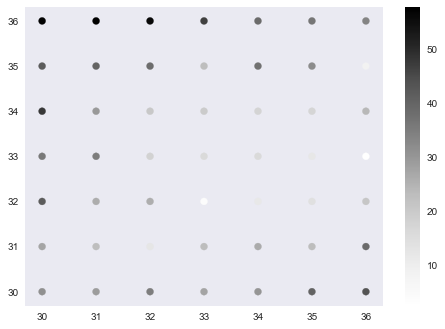

/Users/beckynevin/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:28: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.


<Figure size 576x396 with 0 Axes>

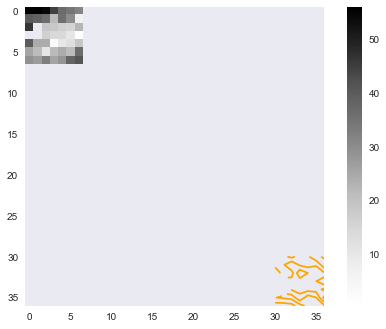

levels [10. 20. 30. 40. 50.]
10.0
CX 3 cY 3


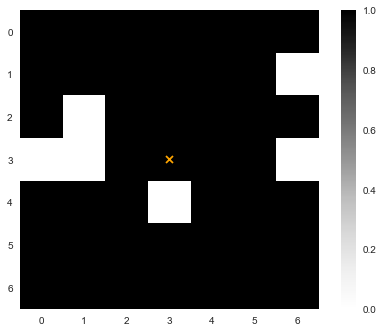

In [98]:
X_list = [30, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33, 34, 34, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36]
Y_list = [30, 31, 32, 33, 34, 35, 36, 30, 31, 32, 33, 34, 35, 36, 30, 31, 32, 33, 34, 35, 36, 30, 31, 32, 33, 34, 35, 36, 30, 31, 32, 33, 34, 35, 36, 30, 31, 32, 33, 34, 35, 36, 30, 31, 32, 33, 34, 35, 36]
A_list =  [31.3867835,  27.39502809, 41.94997676, 35.8873383,  48.01312385, 41.89892618,
 57.44783734, 29.24501949, 23.07120783, 26.08708199, 34.94581161, 29.6621548,
 40.32313837, 57.90649614, 34.85480612, 12.44045129, 26.03693318, 18.05024864,
 20.4993726,  38.25171559, 56.2273543,  27.64268866, 23.26985344,  3.73167051,
 16.1076519,  19.94765248, 23.13089903, 46.64987016, 30.23610239, 26.38101367,
 11.88511257, 15.87397707, 17.67749557, 37.48338052, 38.80098277, 40.3581319,
 23.3956501,  14.16774119, 12.06673863, 17.31707074, 32.12444331, 36.53006157,
 43.58494229, 38.79755223, 20.95553715,  2.40998461, 24.21274059,  8.55955669,
 33.76325233]
A_error =  [2.1647928919765, 1.8940375414254027, 2.095564173344326, np.nan, 1.7153266572655437, 1.627704870051225, 1.7441640405868373, 2.21642348043804, 1.7497705254000502, 1.7491519214552103, np.nan, np.nan, 1.7572187501388283, 1.8868415735464594, 1.8896701794044248, 1.8697589065525406, 1.7482501782225526, 1.706806744096873, 1.6083436537710227, 1.9385621197815306, 1.8804873670629019, 1.9597030239786097, 1.7807040714593523, 1.6584959116175302, 1.6401281455402923, 1.6528616521369568, 1.629459728960628, 2.0336233032107227, 1.934980541798012, 1.8882481839626317, 1.78807146174659, 1.7837327259884692, 1.6250497604937957, 1.6486742535149945, 2.088690169887547, 2.354537392119013, 2.0574496191212077, 1.779870862440849, 1.7825095757944975, 1.8322411288430254, 1.9945422630555911, 2.1461546489668275, 2.3554943406928928, 2.2086947433199486, 1.9893102293922587, 2.0148334011525666, 1.841583109206546, 1.9709971993500688, 2.155985978366906]

A_list_array = np.reshape(np.array(A_list), (7,7))
A_e_list_array = np.reshape(np.array(A_error), (7,7))

A_list_array = A_list_array - A_e_list_array
plt.clf()
plt.scatter(X_list,Y_list,c=A_list)
plt.colorbar()
plt.show()

x = np.linspace(0, np.shape(A_list_array)[0]-1,np.shape(A_list_array)[0])+30
y = (6-np.linspace(0, np.shape(A_list_array)[1]-1, np.shape(A_list_array)[1]))+30
x, y = np.meshgrid(x, y)
plt.clf()
fig, ax = plt.subplots(1, 1)
ax.hold(True)
#im = ax.imshow(data, cmap=plt.cm.jet, origin='bottom')#
im1 = plt.imshow(np.rot90(A_list_array))
cs = ax.contour(x,y, np.rot90(A_list_array), 5, colors='orange')
plt.colorbar(im1)
plt.show()
plt.clf()

p = cs.levels#collections[0].get_paths()[0]


'''Now, snatch the last level and use it to blur everything else out and find the center'''


'''now fill with zeros and do your best to turn into a binary bitmask'''
ret,thresh = cv2.threshold(np.rot90(A_list_array),p[0],1,cv2.THRESH_BINARY)
print('levels', p)
print(p[0])

plt.clf()
plt.imshow(thresh)
plt.colorbar()


M = cv2.moments(thresh)



# calculate x,y coordinate of center
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])

print('CX', cX, 'cY', cY)

plt.scatter(cX,cY, marker='x', color='orange')
plt.show()